In [1]:
 # Install Kaggle

!pip install -q kaggle

In [2]:
# Setup Kaggle API (COMPLETE VERSION)

import os
import json

KAGGLE_USERNAME = "Rawan-Sotohy"
KAGGLE_TOKEN = "KGAT_ab776f256b357ac77ac4467ca48cbaf7"

# Create kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Create kaggle.json
kaggle_config = {
    "username": KAGGLE_USERNAME,
    "key": KAGGLE_TOKEN
}

with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_config, f)

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

print(f"✅ Kaggle configured for user: {KAGGLE_USERNAME}")

✅ Kaggle configured for user: Rawan-Sotohy


In [3]:
# Download Dataset

print("📥 Downloading dataset...")
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

print("📦 Extracting...")
!unzip -q eye-diseases-classification.zip -d ./eye_diseases_data

print("🧹 Cleaning up...")
!rm eye-diseases-classification.zip

print("✅ Done!")

📥 Downloading dataset...
Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
 94% 689M/736M [00:06<00:00, 56.0MB/s]
100% 736M/736M [00:06<00:00, 112MB/s] 
📦 Extracting...
🧹 Cleaning up...
✅ Done!


In [4]:
# Verify

print("\n📁 Dataset Structure:")
for root, dirs, files in os.walk('./eye_diseases_data'):
    level = root.replace('./eye_diseases_data', '').count(os.sep)
    indent = '  ' * level
    print(f'{indent}{os.path.basename(root)}/')
    if level == 1:
        print(f'{indent}  ({len(files)} images)')


📁 Dataset Structure:
eye_diseases_data/
  dataset/
    (0 images)
    diabetic_retinopathy/
    glaucoma/
    cataract/
    normal/


---

In [5]:
# 📊 Eye Diseases Classification Project
#Import Libraries

# Data manipulation
import numpy as np
import pandas as pd
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')


print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


Explore Dataset

In [6]:
# Find the actual data directory
dataset_path = './eye_diseases_data/dataset'

# Count images per class
class_counts = {}
class_names = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        image_count = len([f for f in os.listdir(class_path)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = image_count
        class_names.append(class_name)

print("📊 Images per Class:")
print("="*50)
for class_name, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{class_name:30s}: {count:5d} images")

print(f"\n✅ Total Classes: {len(class_names)}")
print(f"✅ Total Images: {sum(class_counts.values())}")

📊 Images per Class:
diabetic_retinopathy          :  1098 images
normal                        :  1074 images
cataract                      :  1038 images
glaucoma                      :  1007 images

✅ Total Classes: 4
✅ Total Images: 4217


Visualize Class Distribution

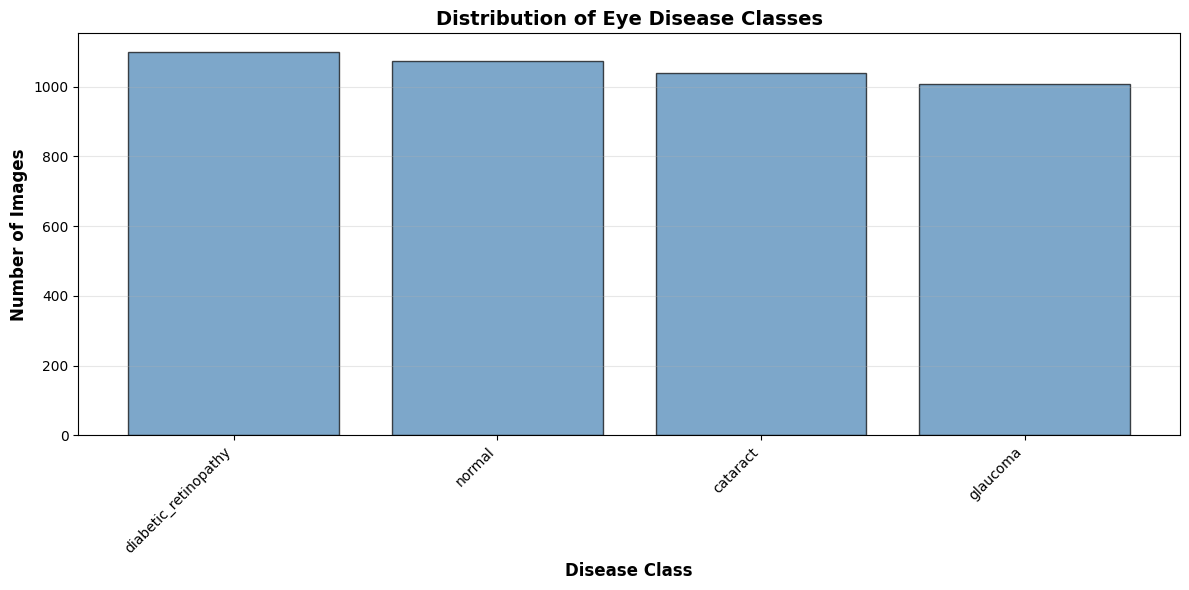

In [7]:
# Plot class distribution
plt.figure(figsize=(12, 6))
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
classes, counts = zip(*sorted_classes)

plt.bar(classes, counts, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Disease Class', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.title('Distribution of Eye Disease Classes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Display Sample Images

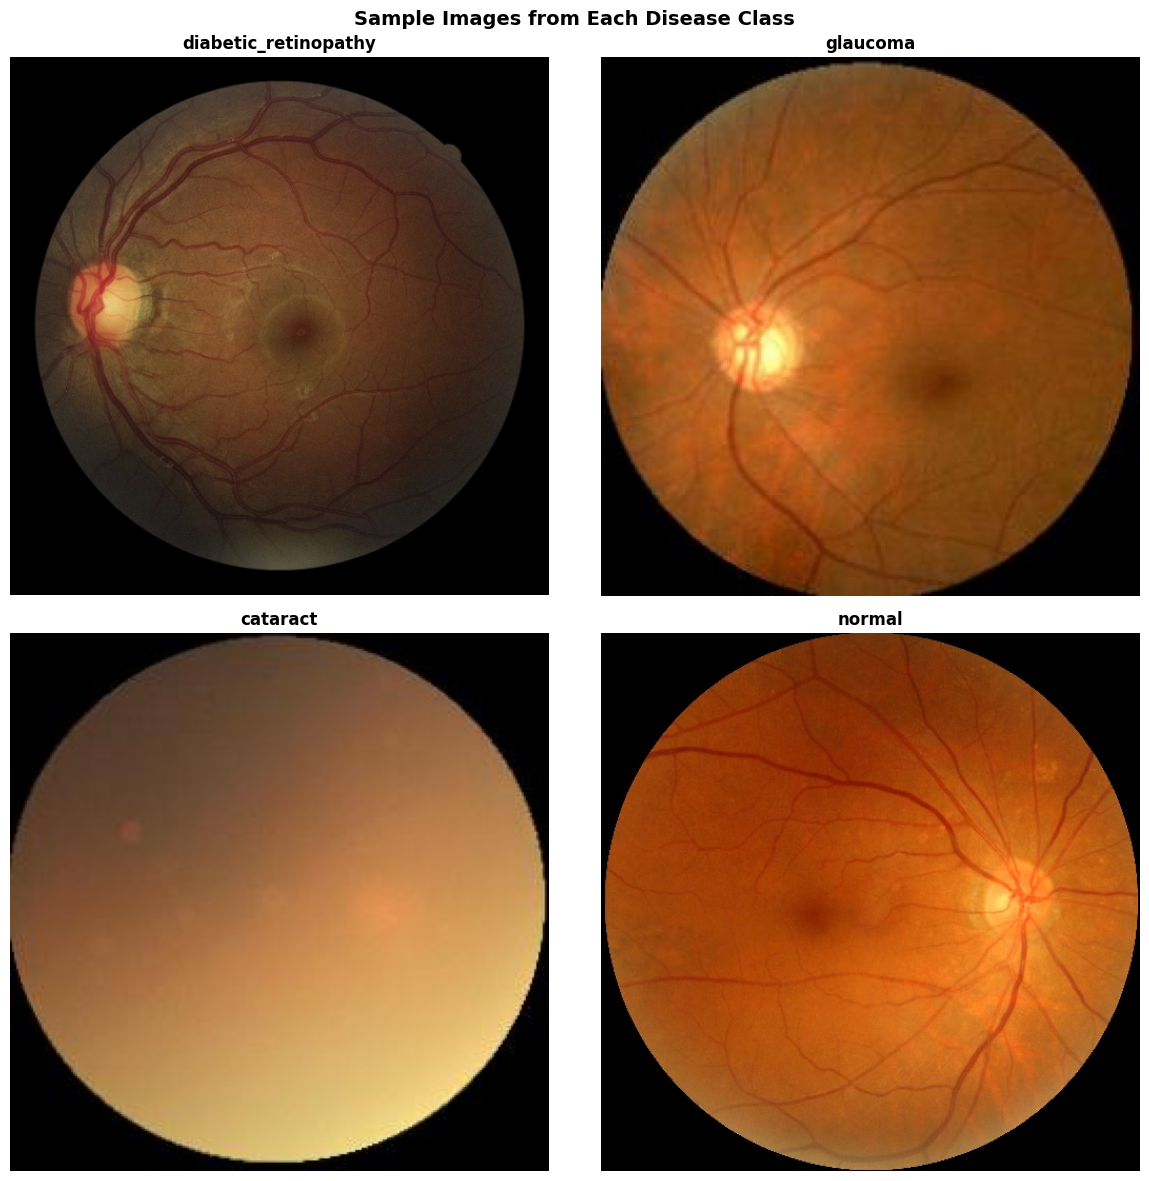

In [8]:
# Display sample images from each class
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, class_name in enumerate(class_names[:4]):
    class_path = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if image_files:
        img_path = os.path.join(class_path, np.random.choice(image_files))
        img = plt.imread(img_path)

        axes[idx].imshow(img)
        axes[idx].set_title(f'{class_name}', fontsize=12, fontweight='bold')
        axes[idx].axis('off')

plt.suptitle('Sample Images from Each Disease Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Setup Image Parameters

In [13]:
# Image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = len(class_names)

print(f"Image Size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Classes: {class_names}")

Image Size: 224x224
Batch Size: 32
Number of Classes: 4
Classes: ['diabetic_retinopathy', 'glaucoma', 'cataract', 'normal']


Create Data Generators

In [14]:
# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80% train, 20% validation
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"\n✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {validation_generator.samples}")

Found 3376 images belonging to 4 classes.
Found 841 images belonging to 4 classes.

✅ Training samples: 3376
✅ Validation samples: 841


 Build Custom CNN

In [15]:
def build_custom_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Build model
custom_cnn = build_custom_cnn()
custom_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,411,044 (100.75 MB)

 Trainable params: 26,408,100 (100.74 MB)

 Non-trainable params: 2,944 (11.50 KB)

 Compile & Train Custom CNN

In [16]:
# Compile
custom_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint('best_custom_cnn.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train
print("🚀 Training Custom CNN...")
history_custom = custom_cnn.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

print("✅ Training completed!")

🚀 Training Custom CNN...
Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.3515 - loss: 1.9632
Epoch 1: val_accuracy improved from -inf to 0.26040, saving model to best_custom_cnn.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 114s 941ms/step - accuracy: 0.3519 - loss: 1.9615 - val_accuracy: 0.2604 - val_loss: 7.5128 - learning_rate: 0.0010
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.4380 - loss: 1.5069
Epoch 2: val_accuracy did not improve from 0.26040
106/106 ━━━━━━━━━━━━━━━━━━━━ 70s 659ms/step - accuracy: 0.4382 - loss: 1.5059 - val_accuracy: 0.2604 - val_loss: 8.1173 - learning_rate: 0.0010
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.5134 - loss: 1.2372
Epoch 3: val_accuracy did not improve from 0.26040
106/106 ━━━━━━━━━━━━━━━━━━━━ 71s 667ms/step - accuracy: 0.5137 - loss: 1.2365 - val_accuracy: 0.2604 - val_loss: 7.4873 - learning_rate: 0.0010
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.6048 - loss: 1.00

Plot Training History

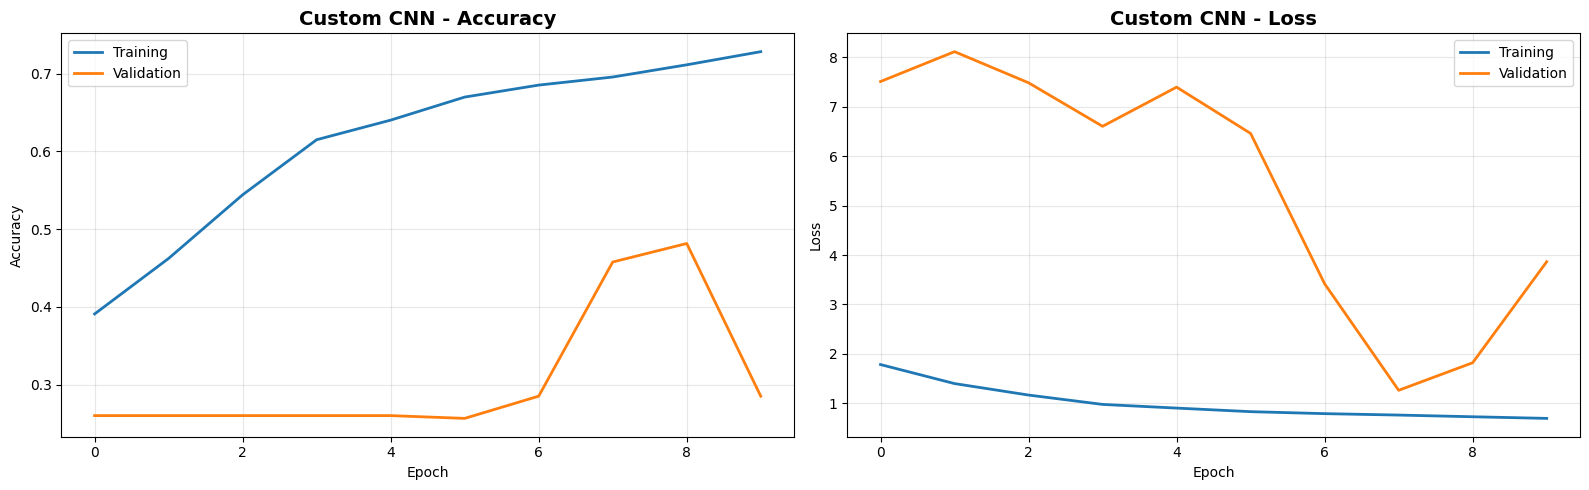

In [17]:
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_title(f'{title} - Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(history.history['loss'], label='Training', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax2.set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_history(history_custom, 'Custom CNN')

Build VGG16 Transfer Learning

In [18]:
# Build VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

vgg16_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

vgg16_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ VGG16 model built!")
vgg16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
✅ VGG16 model built!


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,772 (57.65 MB)

 Trainable params: 396,548 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

Train VGG16

🚀 Training VGG16...
Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.4258 - loss: 1.5907
Epoch 1: val_accuracy improved from -inf to 0.39834, saving model to best_vgg16.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 106s 836ms/step - accuracy: 0.4264 - loss: 1.5885 - val_accuracy: 0.3983 - val_loss: 1.3443 - learning_rate: 1.0000e-04
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.5689 - loss: 1.1207
Epoch 2: val_accuracy improved from 0.39834 to 0.44709, saving model to best_vgg16.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 73s 686ms/step - accuracy: 0.5691 - loss: 1.1201 - val_accuracy: 0.4471 - val_loss: 1.2299 - learning_rate: 1.0000e-04
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.6321 - loss: 0.9390
Epoch 3: val_accuracy improved from 0.44709 to 0.59929, saving model to best_vgg16.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 73s 685ms/step - accuracy: 0.6322 - loss: 0.9388 - val_accuracy: 0.5993 - val_loss: 1.0191 - learning_rate: 1.0000e-04
Epoch 4

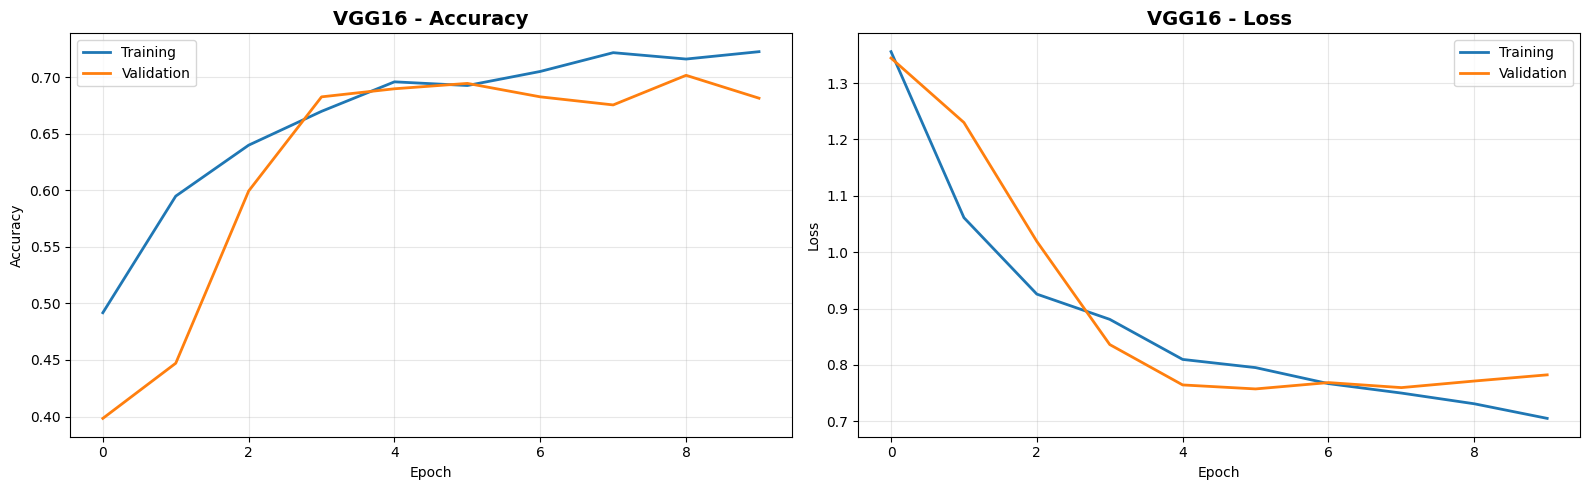

In [19]:
checkpoint_vgg = ModelCheckpoint('best_vgg16.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

print("🚀 Training VGG16...")
history_vgg16 = vgg16_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint_vgg],
    verbose=1
)

plot_history(history_vgg16, 'VGG16')

Evaluate & Compare Models

📊 Evaluating Custom CNN...
Custom CNN - Loss: 1.2420, Accuracy: 0.4423

📊 Evaluating VGG16...
VGG16 - Loss: 0.7845, Accuracy: 0.6659

📈 Model Comparison:
     Model  Accuracy     Loss
Custom CNN  0.442331 1.241965
     VGG16  0.665874 0.784534


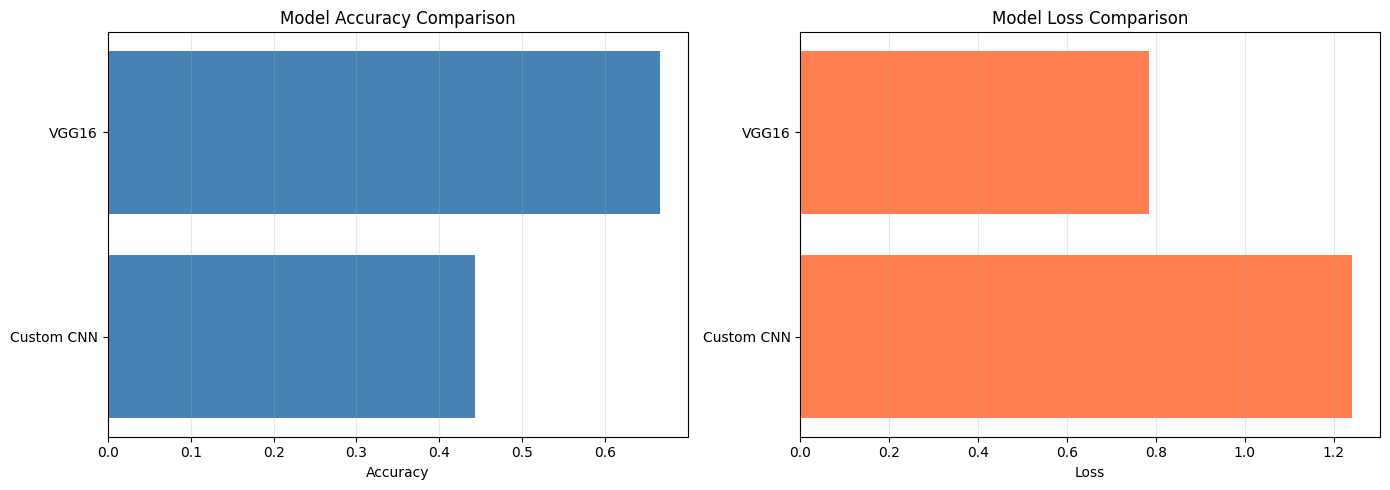

In [20]:
# Evaluate Custom CNN
print("📊 Evaluating Custom CNN...")
loss_cnn, acc_cnn = custom_cnn.evaluate(validation_generator, verbose=0)
print(f"Custom CNN - Loss: {loss_cnn:.4f}, Accuracy: {acc_cnn:.4f}")

# Evaluate VGG16
print("\n📊 Evaluating VGG16...")
loss_vgg, acc_vgg = vgg16_model.evaluate(validation_generator, verbose=0)
print(f"VGG16 - Loss: {loss_vgg:.4f}, Accuracy: {acc_vgg:.4f}")

# Comparison
comparison = pd.DataFrame({
    'Model': ['Custom CNN', 'VGG16'],
    'Accuracy': [acc_cnn, acc_vgg],
    'Loss': [loss_cnn, loss_vgg]
})

print("\n📈 Model Comparison:")
print(comparison.to_string(index=False))

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.barh(comparison['Model'], comparison['Accuracy'], color='steelblue')
ax1.set_xlabel('Accuracy')
ax1.set_title('Model Accuracy Comparison')
ax1.grid(axis='x', alpha=0.3)

ax2.barh(comparison['Model'], comparison['Loss'], color='coral')
ax2.set_xlabel('Loss')
ax2.set_title('Model Loss Comparison')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Build ResNet50 Model

In [21]:
"""
# Transfer Learning - ResNet50
"""

# Build ResNet50
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_resnet.trainable = False

resnet_model = models.Sequential([
    base_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ ResNet50 model built!")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
✅ ResNet50 model built!


Train ResNet50

🚀 Training ResNet50...
Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.3180 - loss: 1.8965
Epoch 1: val_accuracy improved from -inf to 0.24614, saving model to best_resnet50.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 96s 774ms/step - accuracy: 0.3182 - loss: 1.8954 - val_accuracy: 0.2461 - val_loss: 1.4232 - learning_rate: 1.0000e-04
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.3696 - loss: 1.6469
Epoch 2: val_accuracy did not improve from 0.24614
106/106 ━━━━━━━━━━━━━━━━━━━━ 68s 641ms/step - accuracy: 0.3697 - loss: 1.6467 - val_accuracy: 0.2426 - val_loss: 1.4918 - learning_rate: 1.0000e-04
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.3900 - loss: 1.5312
Epoch 3: val_accuracy did not improve from 0.24614
106/106 ━━━━━━━━━━━━━━━━━━━━ 69s 650ms/step - accuracy: 0.3900 - loss: 1.5312 - val_accuracy: 0.2390 - val_loss: 1.8163 - learning_rate: 1.0000e-04
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.4102 - los

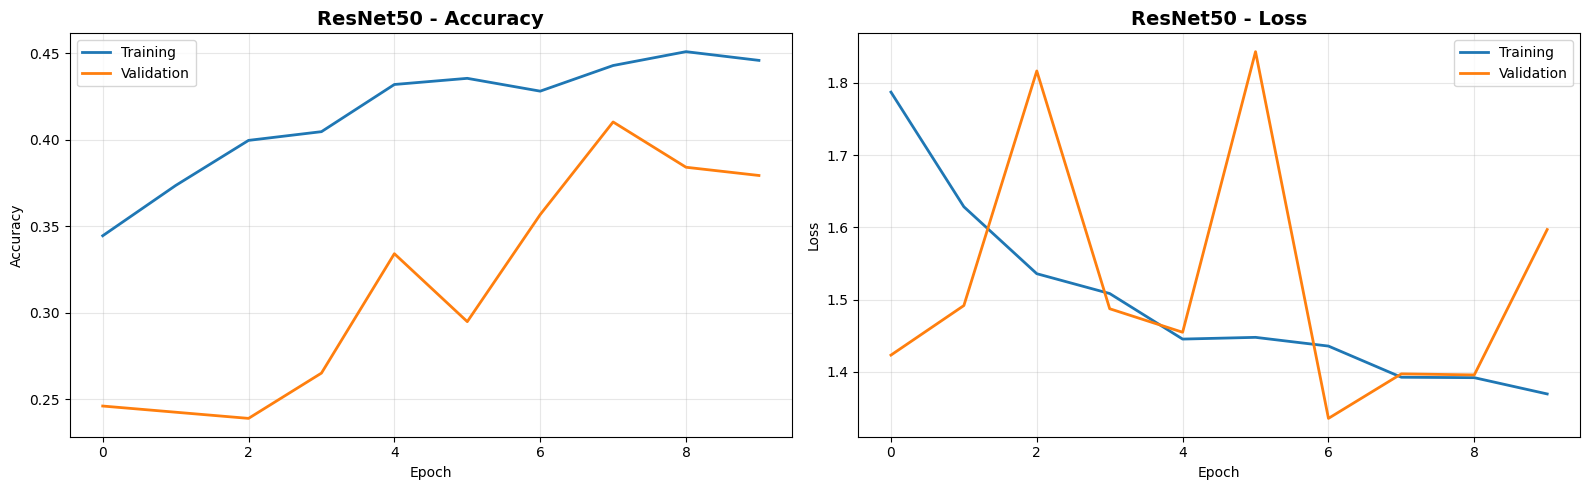

In [22]:
checkpoint_resnet = ModelCheckpoint('best_resnet50.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

print("🚀 Training ResNet50...")
history_resnet = resnet_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint_resnet],
    verbose=1
)

plot_history(history_resnet, 'ResNet50')

Build EfficientNetB0 Model

In [23]:
"""
# Transfer Learning - EfficientNetB0
"""

# Build EfficientNet
base_efficient = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_efficient.trainable = False

efficientnet_model = models.Sequential([
    base_efficient,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

efficientnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ EfficientNetB0 model built!")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
✅ EfficientNetB0 model built!


Train EfficientNetB0

🚀 Training EfficientNetB0...
Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.2330 - loss: 2.1093
Epoch 1: val_accuracy improved from -inf to 0.24614, saving model to best_efficientnet.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 128s 948ms/step - accuracy: 0.2331 - loss: 2.1086 - val_accuracy: 0.2461 - val_loss: 1.4890 - learning_rate: 1.0000e-04
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.2537 - loss: 1.8760
Epoch 2: val_accuracy improved from 0.24614 to 0.26040, saving model to best_efficientnet.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 67s 635ms/step - accuracy: 0.2537 - loss: 1.8759 - val_accuracy: 0.2604 - val_loss: 1.4683 - learning_rate: 1.0000e-04
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.2674 - loss: 1.8590
Epoch 3: val_accuracy did not improve from 0.26040
106/106 ━━━━━━━━━━━━━━━━━━━━ 66s 625ms/step - accuracy: 0.2673 - loss: 1.8591 - val_accuracy: 0.2461 - val_loss: 1.6432 - learning_rate: 1.0000e-04
Epoch 4/10
106/106 ━━━

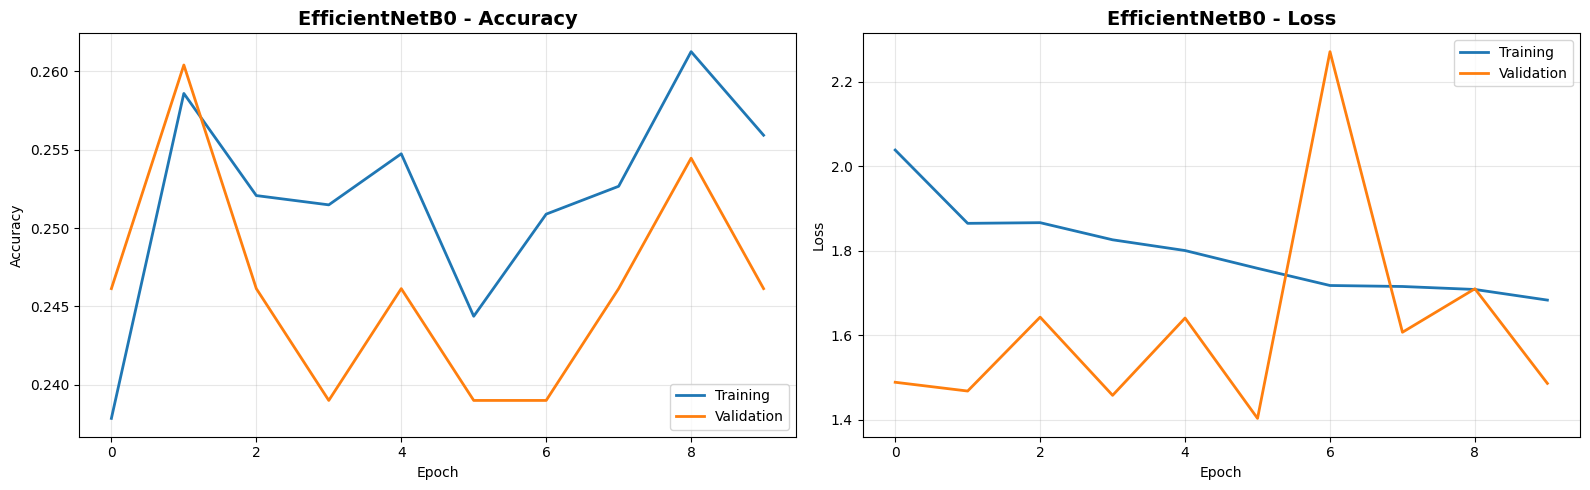

In [24]:
checkpoint_efficient = ModelCheckpoint('best_efficientnet.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

print("🚀 Training EfficientNetB0...")
history_efficient = efficientnet_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint_efficient],
    verbose=1
)

plot_history(history_efficient, 'EfficientNetB0')

 Fine-tuning VGG16 (Unfreeze Layers)

In [25]:
"""
# Fine-tuning - Unfreeze last layers of VGG16
"""

# Load best VGG16 weights
vgg16_finetuned = keras.models.load_model('best_vgg16.keras')

# Unfreeze last 4 layers of base model
base_model_vgg = vgg16_finetuned.layers[0]
base_model_vgg.trainable = True

# Freeze all except last 4 layers
for layer in base_model_vgg.layers[:-4]:
    layer.trainable = False

print(f"Total layers in VGG16: {len(base_model_vgg.layers)}")
print(f"Trainable layers: {sum([1 for layer in base_model_vgg.layers if layer.trainable])}")

# Compile with lower learning rate
vgg16_finetuned.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ VGG16 ready for fine-tuning!")

Total layers in VGG16: 19
Trainable layers: 4
✅ VGG16 ready for fine-tuning!


Train Fine-tuned VGG16

🚀 Fine-tuning VGG16...
Epoch 1/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.7289 - loss: 0.7199
Epoch 1: val_accuracy improved from -inf to 0.72652, saving model to best_vgg16_finetuned.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 88s 752ms/step - accuracy: 0.7290 - loss: 0.7197 - val_accuracy: 0.7265 - val_loss: 0.7116 - learning_rate: 1.0000e-05
Epoch 2/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.7612 - loss: 0.6054
Epoch 2: val_accuracy did not improve from 0.72652
106/106 ━━━━━━━━━━━━━━━━━━━━ 73s 689ms/step - accuracy: 0.7611 - loss: 0.6056 - val_accuracy: 0.6920 - val_loss: 0.7592 - learning_rate: 1.0000e-05
Epoch 3/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.7743 - loss: 0.5922
Epoch 3: val_accuracy did not improve from 0.72652
106/106 ━━━━━━━━━━━━━━━━━━━━ 73s 692ms/step - accuracy: 0.7743 - loss: 0.5922 - val_accuracy: 0.6647 - val_loss: 0.7883 - learning_rate: 1.0000e-05
Epoch 4/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.777

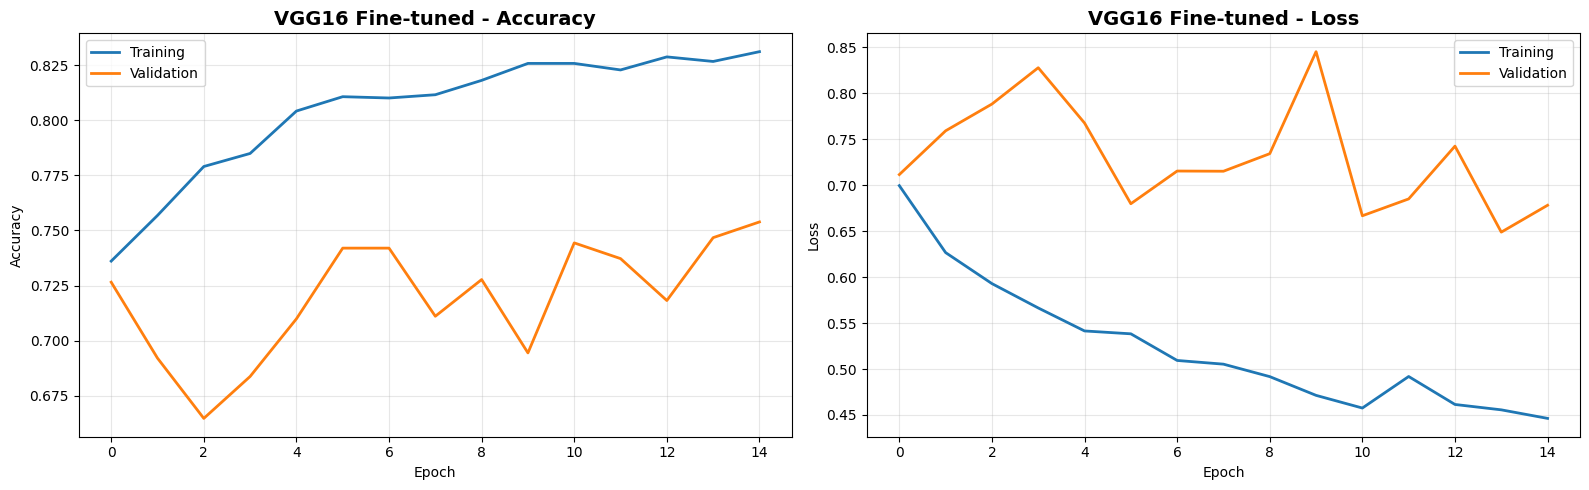

In [26]:
checkpoint_vgg_ft = ModelCheckpoint('best_vgg16_finetuned.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

print("🚀 Fine-tuning VGG16...")
history_vgg_ft = vgg16_finetuned.fit(
    train_generator,
    epochs=15,  # Fewer epochs for fine-tuning
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint_vgg_ft],
    verbose=1
)

plot_history(history_vgg_ft, 'VGG16 Fine-tuned')

Comprehensive Model Comparison

In [27]:
"""
# Evaluate ALL Models
"""

# Evaluate all models
models_list = [
    ('Custom CNN', custom_cnn),
    ('VGG16', vgg16_model),
    ('ResNet50', resnet_model),
    ('EfficientNetB0', efficientnet_model),
    ('VGG16 Fine-tuned', vgg16_finetuned)
]

results = []

for name, model in models_list:
    print(f"\n📊 Evaluating {name}...")
    loss, accuracy = model.evaluate(validation_generator, verbose=0)
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Loss': loss
    })
    print(f"   Loss: {loss:.4f} | Accuracy: {accuracy:.4f}")

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print("\n" + "="*60)
print("📈 FINAL MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

# Save to CSV
comparison_df.to_csv('model_comparison.csv', index=False)
print("\n✅ Results saved to 'model_comparison.csv'")


📊 Evaluating Custom CNN...
   Loss: 1.2628 | Accuracy: 0.4602

📊 Evaluating VGG16...
   Loss: 0.7748 | Accuracy: 0.6730

📊 Evaluating ResNet50...
   Loss: 1.3504 | Accuracy: 0.3734

📊 Evaluating EfficientNetB0...
   Loss: 1.4042 | Accuracy: 0.2390

📊 Evaluating VGG16 Fine-tuned...
   Loss: 0.6521 | Accuracy: 0.7467

📈 FINAL MODEL COMPARISON
           Model  Accuracy     Loss
VGG16 Fine-tuned  0.746730 0.652067
           VGG16  0.673008 0.774766
      Custom CNN  0.460166 1.262828
        ResNet50  0.373365 1.350406
  EfficientNetB0  0.239001 1.404199

✅ Results saved to 'model_comparison.csv'


Visualize Final Comparison

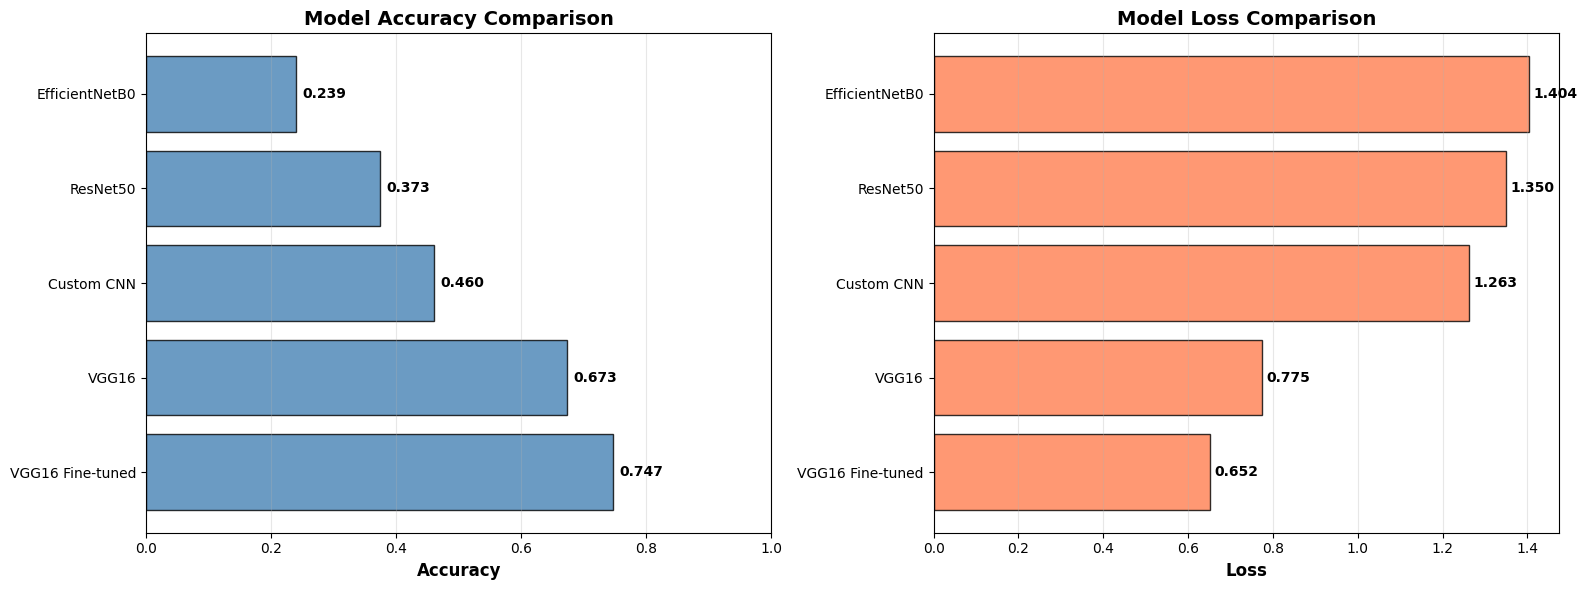


🏆 BEST MODEL: VGG16 Fine-tuned
   Accuracy: 0.7467 (74.67%)


In [28]:
# Plot comprehensive comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
axes[0].barh(comparison_df['Model'], comparison_df['Accuracy'], color='steelblue', edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].set_xlim([0, 1])

# Add value labels
for i, (model, acc) in enumerate(zip(comparison_df['Model'], comparison_df['Accuracy'])):
    axes[0].text(acc + 0.01, i, f'{acc:.3f}', va='center', fontweight='bold')

# Loss comparison
axes[1].barh(comparison_df['Model'], comparison_df['Loss'], color='coral', edgecolor='black', alpha=0.8)
axes[1].set_xlabel('Loss', fontsize=12, fontweight='bold')
axes[1].set_title('Model Loss Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, (model, loss) in enumerate(zip(comparison_df['Model'], comparison_df['Loss'])):
    axes[1].text(loss + 0.01, i, f'{loss:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Accuracy']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

Confusion Matrix for Best Model

27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 450ms/step


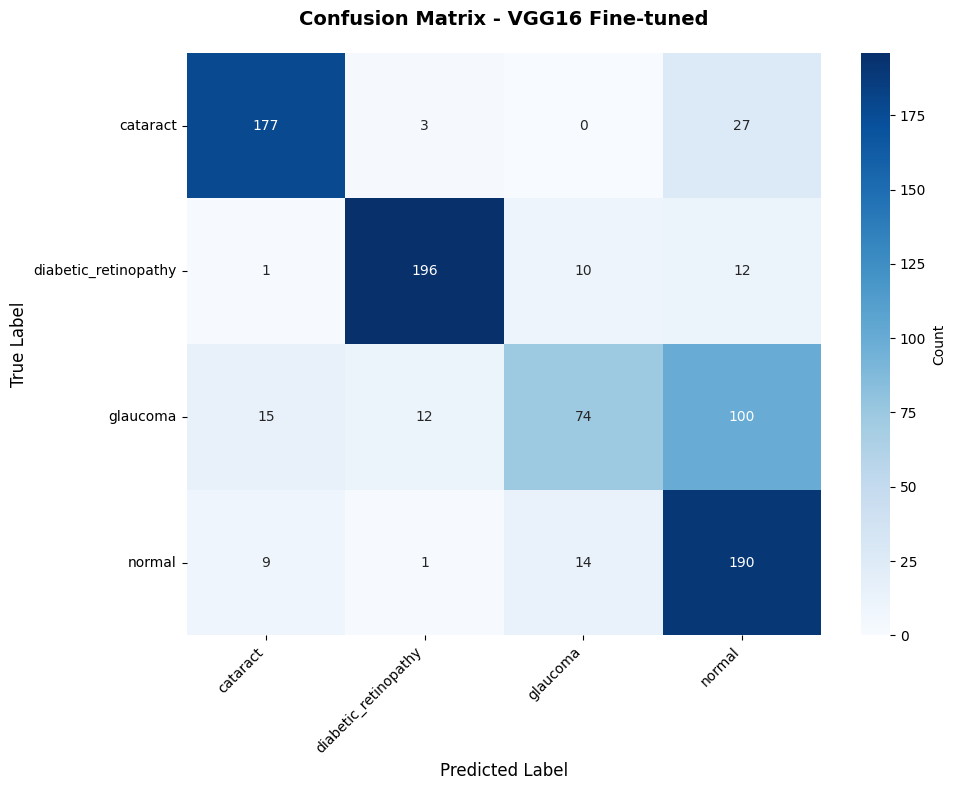

In [29]:
"""
# Confusion Matrix Analysis
"""

# Get best model
best_model_idx = comparison_df['Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']

# Load best model
model_files = {
    'Custom CNN': 'best_custom_cnn.keras',
    'VGG16': 'best_vgg16.keras',
    'ResNet50': 'best_resnet50.keras',
    'EfficientNetB0': 'best_efficientnet.keras',
    'VGG16 Fine-tuned': 'best_vgg16_finetuned.keras'
}

best_model = keras.models.load_model(model_files[best_model_name])

# Get predictions
validation_generator.reset()
predictions = best_model.predict(validation_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Get class names
class_names_list = list(validation_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_list,
            yticklabels=class_names_list,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Classification Report

In [30]:
"""
# Detailed Classification Report
"""

from sklearn.metrics import classification_report

print("="*70)
print(f"CLASSIFICATION REPORT - {best_model_name}")
print("="*70)
print()

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names_list,
    digits=4
)

print(report)

# Save report
with open('classification_report.txt', 'w') as f:
    f.write(f"Classification Report - {best_model_name}\n")
    f.write("="*70 + "\n")
    f.write(report)

print("\n✅ Report saved to 'classification_report.txt'")

CLASSIFICATION REPORT - VGG16 Fine-tuned

                      precision    recall  f1-score   support

            cataract     0.8762    0.8551    0.8655       207
diabetic_retinopathy     0.9245    0.8950    0.9095       219
            glaucoma     0.7551    0.3682    0.4950       201
              normal     0.5775    0.8879    0.6998       214

            accuracy                         0.7574       841
           macro avg     0.7833    0.7515    0.7425       841
        weighted avg     0.7838    0.7574    0.7463       841


✅ Report saved to 'classification_report.txt'


 Per-Class Accuracy Visualizatio


📊 Per-Class Performance:
               Class  Precision   Recall  F1-Score  Support
            cataract   0.876238 0.855072  0.865526      207
diabetic_retinopathy   0.924528 0.894977  0.909513      219
            glaucoma   0.755102 0.368159  0.494983      201
              normal   0.577508 0.887850  0.699816      214


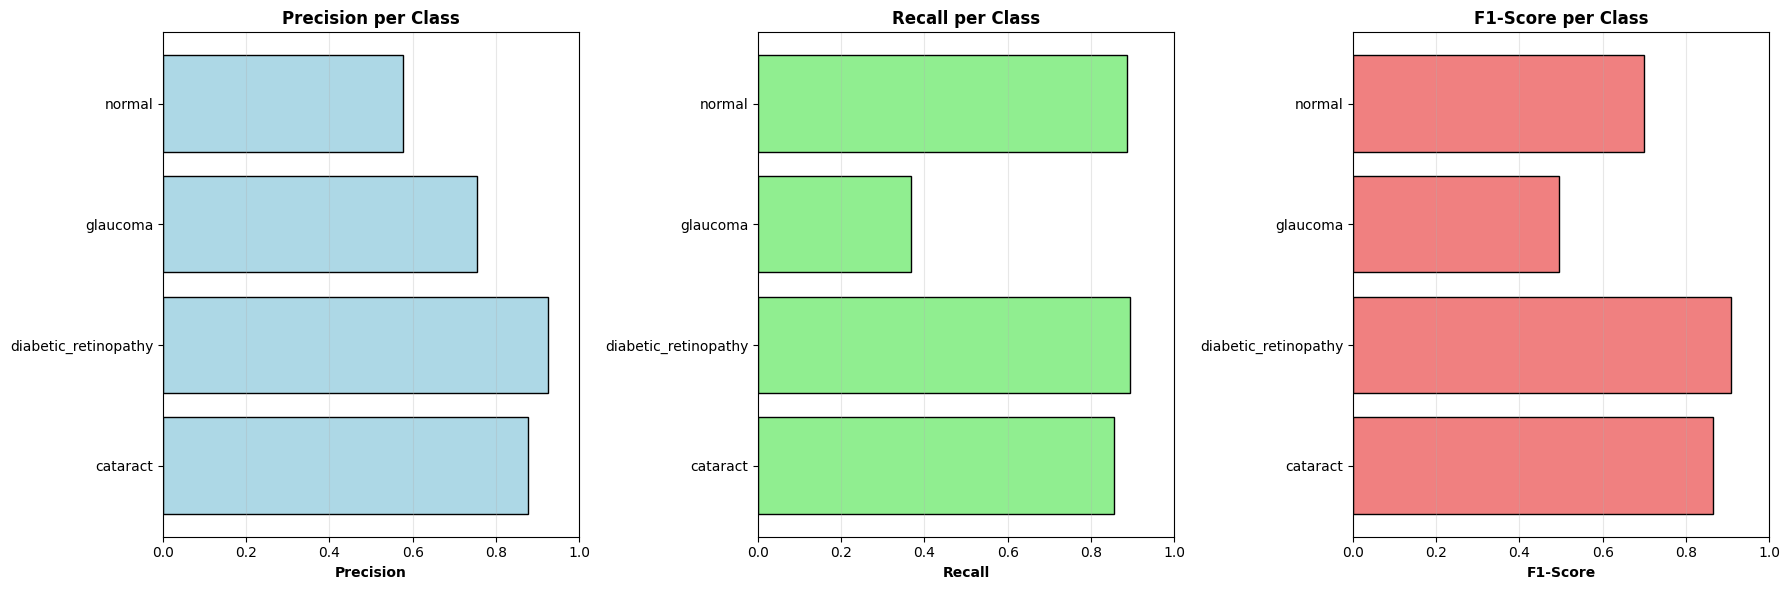

In [31]:
"""
# Per-Class Performance Analysis
"""

from sklearn.metrics import precision_recall_fscore_support

# Calculate metrics per class
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, labels=range(len(class_names_list))
)

# Create DataFrame
metrics_df = pd.DataFrame({
    'Class': class_names_list,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\n📊 Per-Class Performance:")
print("="*70)
print(metrics_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision
axes[0].barh(metrics_df['Class'], metrics_df['Precision'], color='lightblue', edgecolor='black')
axes[0].set_xlabel('Precision', fontweight='bold')
axes[0].set_title('Precision per Class', fontweight='bold')
axes[0].set_xlim([0, 1])
axes[0].grid(axis='x', alpha=0.3)

# Recall
axes[1].barh(metrics_df['Class'], metrics_df['Recall'], color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Recall', fontweight='bold')
axes[1].set_title('Recall per Class', fontweight='bold')
axes[1].set_xlim([0, 1])
axes[1].grid(axis='x', alpha=0.3)

# F1-Score
axes[2].barh(metrics_df['Class'], metrics_df['F1-Score'], color='lightcoral', edgecolor='black')
axes[2].set_xlabel('F1-Score', fontweight='bold')
axes[2].set_title('F1-Score per Class', fontweight='bold')
axes[2].set_xlim([0, 1])
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Sample Predictions Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step


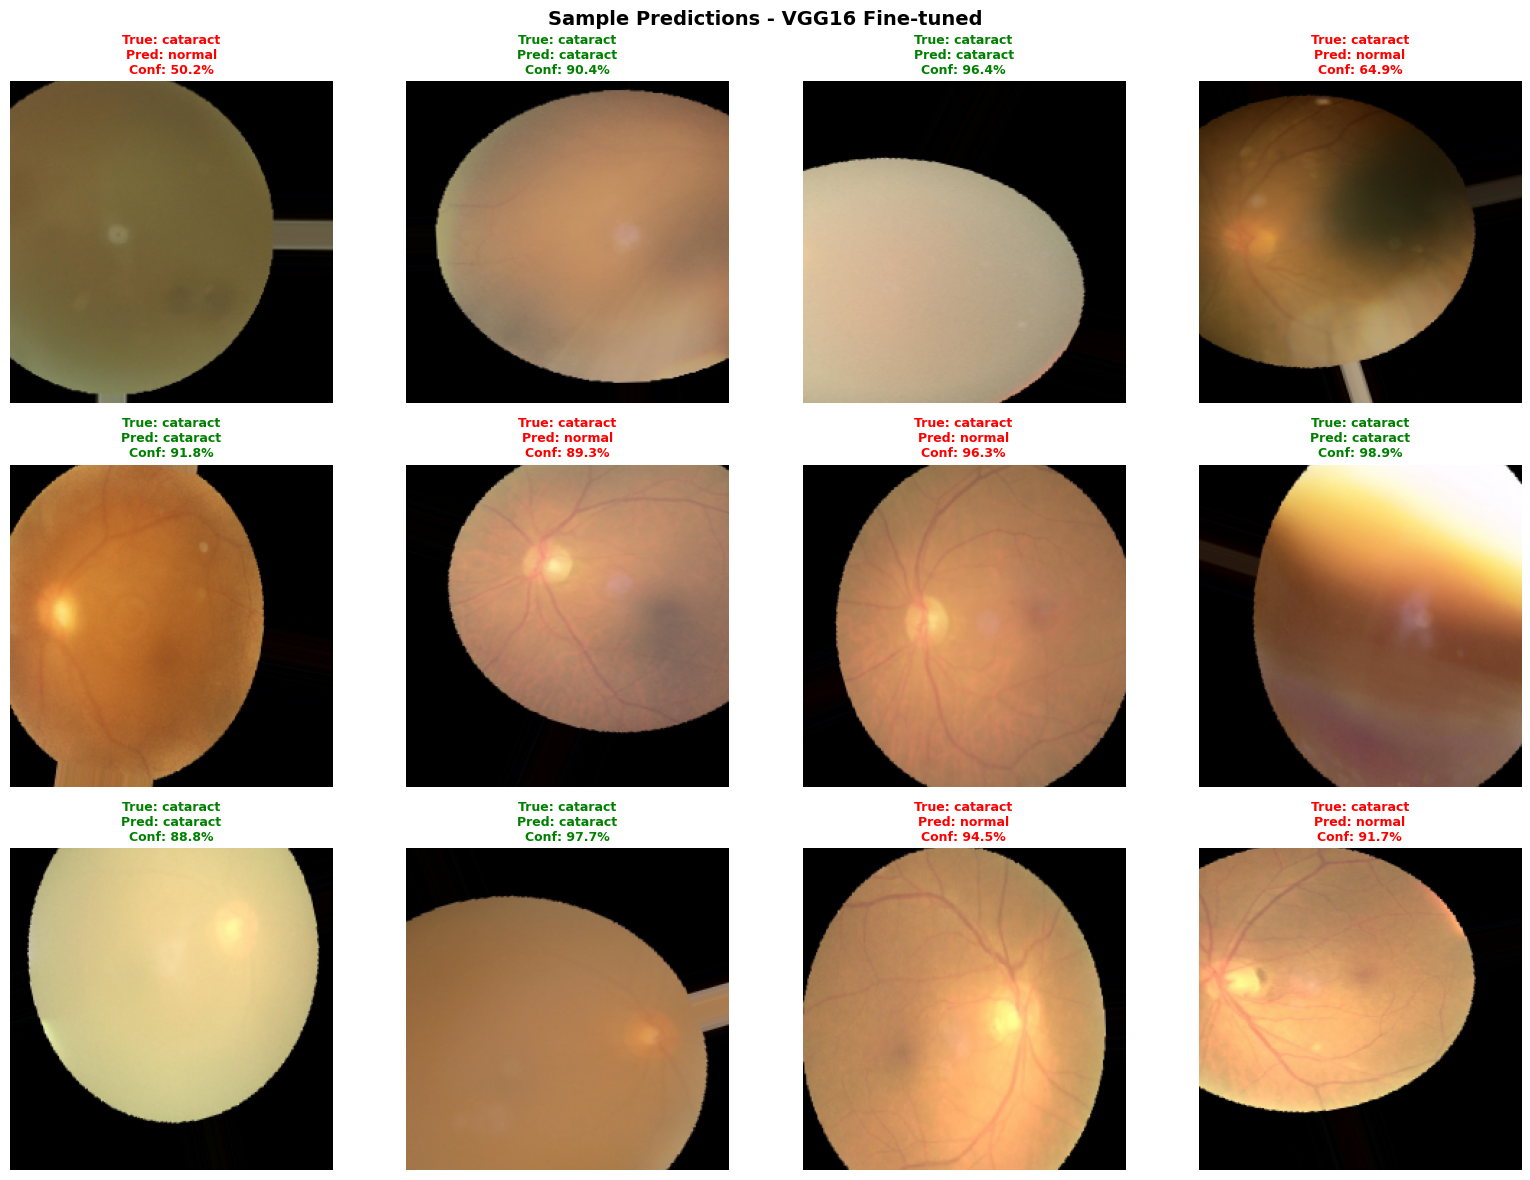

In [32]:
"""
# Visualize Sample Predictions
"""

# Get a batch of validation images
validation_generator.reset()
sample_images, sample_labels = next(validation_generator)

# Predict
sample_predictions = best_model.predict(sample_images)
sample_pred_classes = np.argmax(sample_predictions, axis=1)
sample_true_classes = np.argmax(sample_labels, axis=1)

# Plot
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i in range(12):
    axes[i].imshow(sample_images[i])

    true_label = class_names_list[sample_true_classes[i]]
    pred_label = class_names_list[sample_pred_classes[i]]
    confidence = sample_predictions[i][sample_pred_classes[i]] * 100

    # Color: green if correct, red if wrong
    color = 'green' if true_label == pred_label else 'red'

    axes[i].set_title(
        f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
        fontsize=9,
        color=color,
        fontweight='bold'
    )
    axes[i].axis('off')

plt.suptitle(f'Sample Predictions - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Training Time Comparison

In [33]:
"""
# Training Time Analysis
"""

# Calculate training times (approximate from history)
training_times = []

for name, history in [
    ('Custom CNN', history_custom),
    ('VGG16', history_vgg16),
    ('ResNet50', history_resnet),
    ('EfficientNetB0', history_efficient),
    ('VGG16 Fine-tuned', history_vgg_ft)
]:
    epochs_trained = len(history.history['loss'])
    training_times.append({
        'Model': name,
        'Epochs': epochs_trained,
        'Final Train Acc': history.history['accuracy'][-1],
        'Final Val Acc': history.history['val_accuracy'][-1]
    })

training_df = pd.DataFrame(training_times)

print("\n📊 Training Summary:")
print("="*70)
print(training_df.to_string(index=False))


📊 Training Summary:
           Model  Epochs  Final Train Acc  Final Val Acc
      Custom CNN      10         0.728081       0.285375
           VGG16      10         0.722453       0.681332
        ResNet50      10         0.445794       0.379310
  EfficientNetB0      10         0.255924       0.246136
VGG16 Fine-tuned      15         0.831161       0.753864


Save All Training Histories

In [34]:
"""
# Save Training Histories for Future Analysis
"""

import pickle

# Compile all histories
all_histories = {
    'custom_cnn': history_custom.history,
    'vgg16': history_vgg16.history,
    'resnet50': history_resnet.history,
    'efficientnet': history_efficient.history,
    'vgg16_finetuned': history_vgg_ft.history
}

# Save to pickle
with open('training_histories.pkl', 'wb') as f:
    pickle.dump(all_histories, f)

print("✅ Training histories saved to 'training_histories.pkl'")

# Also save as JSON for readability
import json

histories_json = {}
for name, hist in all_histories.items():
    histories_json[name] = {
        'accuracy': [float(x) for x in hist['accuracy']],
        'val_accuracy': [float(x) for x in hist['val_accuracy']],
        'loss': [float(x) for x in hist['loss']],
        'val_loss': [float(x) for x in hist['val_loss']]
    }

with open('training_histories.json', 'w') as f:
    json.dump(histories_json, f, indent=2)

print("✅ Training histories also saved to 'training_histories.json'")

✅ Training histories saved to 'training_histories.pkl'
✅ Training histories also saved to 'training_histories.json'


Combined Learning Curves

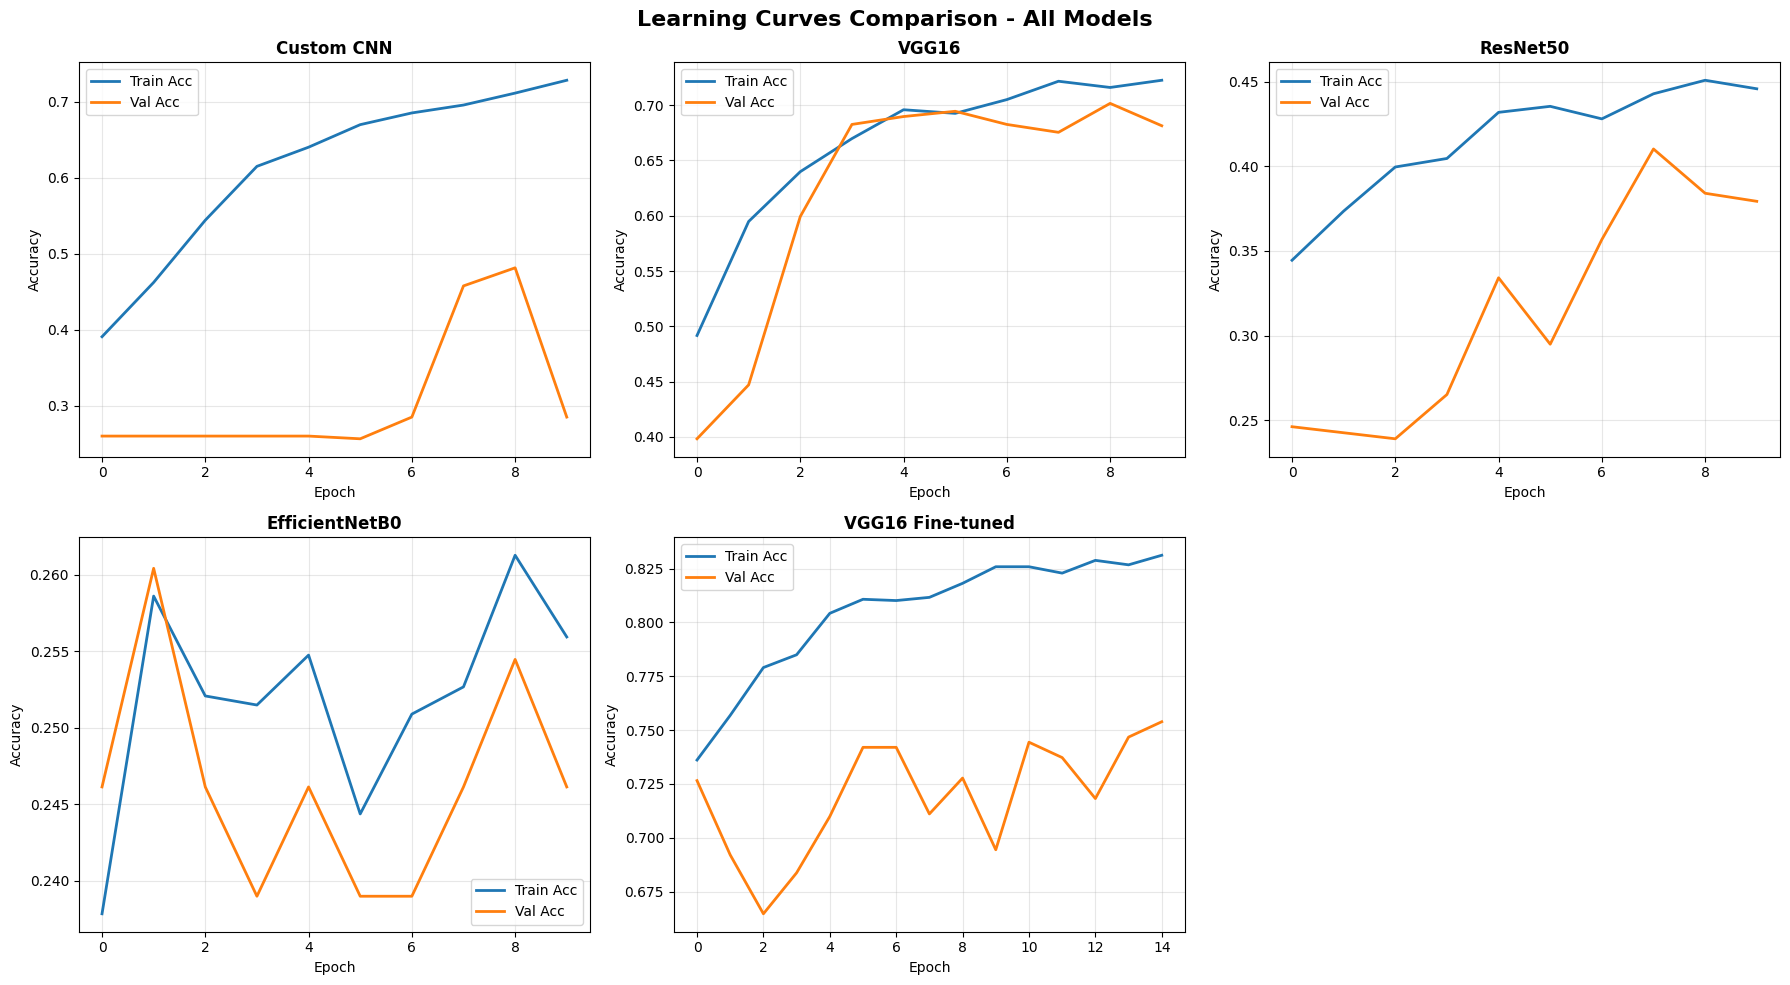

In [35]:
"""
# Compare All Learning Curves
"""

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

histories_plot = [
    ('Custom CNN', history_custom),
    ('VGG16', history_vgg16),
    ('ResNet50', history_resnet),
    ('EfficientNetB0', history_efficient),
    ('VGG16 Fine-tuned', history_vgg_ft)
]

for idx, (name, history) in enumerate(histories_plot):
    ax = axes[idx]

    ax.plot(history.history['accuracy'], label='Train Acc', linewidth=2)
    ax.plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide the last empty subplot
axes[-1].axis('off')

plt.suptitle('Learning Curves Comparison - All Models', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Final Project Summary

In [36]:
"""
# 🎉 PROJECT SUMMARY
"""

print("\n" + "="*70)
print("🎉 EYE DISEASES CLASSIFICATION PROJECT - COMPLETED!")
print("="*70)

print(f"\n📊 Dataset Information:")
print(f"   Total Images: {sum(class_counts.values())}")
print(f"   Number of Classes: {len(class_names)}")
print(f"   Classes: {', '.join(class_names)}")
print(f"   Training Samples: {train_generator.samples}")
print(f"   Validation Samples: {validation_generator.samples}")

print(f"\n🤖 Models Trained:")
print(f"   1. Custom CNN from Scratch")
print(f"   2. VGG16 (Transfer Learning)")
print(f"   3. ResNet50 (Transfer Learning)")
print(f"   4. EfficientNetB0 (Transfer Learning)")
print(f"   5. VGG16 Fine-tuned")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

print(f"\n📁 Saved Files:")
print(f"   • best_custom_cnn.keras")
print(f"   • best_vgg16.keras")
print(f"   • best_resnet50.keras")
print(f"   • best_efficientnet.keras")
print(f"   • best_vgg16_finetuned.keras")
print(f"   • model_comparison.csv")
print(f"   • classification_report.txt")
print(f"   • training_histories.pkl")
print(f"   • training_histories.json")

print("\n" + "="*70)
print("✅ All tasks completed successfully!")
print("="*70)



🎉 EYE DISEASES CLASSIFICATION PROJECT - COMPLETED!

📊 Dataset Information:
   Total Images: 4217
   Number of Classes: 4
   Classes: diabetic_retinopathy, glaucoma, cataract, normal
   Training Samples: 3376
   Validation Samples: 841

🤖 Models Trained:
   1. Custom CNN from Scratch
   2. VGG16 (Transfer Learning)
   3. ResNet50 (Transfer Learning)
   4. EfficientNetB0 (Transfer Learning)
   5. VGG16 Fine-tuned

🏆 Best Model: VGG16 Fine-tuned
   Accuracy: 0.7467 (74.67%)

📁 Saved Files:
   • best_custom_cnn.keras
   • best_vgg16.keras
   • best_resnet50.keras
   • best_efficientnet.keras
   • best_vgg16_finetuned.keras
   • model_comparison.csv
   • classification_report.txt
   • training_histories.pkl
   • training_histories.json

✅ All tasks completed successfully!


---